<h1><center>MS BGD - TP Avazu<center></h1>


# Introduction

In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding. The goal of this TP is to build and test prediction models on 11 days of Avazu data.



In [3]:
import sys
from zipfile import ZipFile
import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

AVAZU_URL = "https://bianchi.wp.imt.fr/files/2019/05/train-1000000.zip"
AVAZU_FILENAME = AVAZU_URL.rsplit('/', 1)[1]


if not op.exists(AVAZU_FILENAME):
    print('Downloading %s to %s...' % (AVAZU_URL, AVAZU_FILENAME))
    urlretrieve(AVAZU_URL, AVAZU_FILENAME)
    print('Extracting to %s...' % AVAZU_FILENAME)
    ZipFile(AVAZU_FILENAME).extractall('.')

<font color="red">**Question:**
    Import the needed packages: numpy, pandas etc..
</font>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

# The dataset

<font color="red">**Question:**
Load the data *'train-1000000'* into a pandas DataFrame. Then, display the first lines with the ".head()" method.
</font>
**Remark**: the features meaning is available at https://www.kaggle.com/c/avazu-ctr-prediction/data

In [5]:
df = pd.read_csv('train-1000000')

In [6]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23


<font color="red">**Question:**
    What is the 'click' frequency in the dataset?
    <br>
    Hint: 'click' is a binary output (0 or 1)
</font>

In [7]:
click_freq = df['click'].mean()
print(click_freq)

0.169971


We note that the Avazu dataset is very unbalanced. The 'click' class represents less than a fifth of the whole database. We already know that a classifier always predicting 'click'=0 will have good preformances in terms of error rate (around 0.17). The ROC curve will be better performance metrics.

<font color="red">**Question:**
    What are the categorical features? Using the 'df.nunique()' method, compute the number of distincts values for each of these features.
</font>

In [8]:
print(df.nunique())

id                  1000000
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                2651
site_domain            2871
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_id            150501
device_ip            555248
device_model           5168
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
dtype: int64


<font color="red">**Question:**
    If one does a dummy encoding of all categorical variables, what would be the dimension of the model?
    In other words: what would be the dimension of our big feature vector encoded with dummies.
    <br>
    Hint: if you have just 1 feature with 3 categories A, B and C, you would have a vector of dimension 3 (or 2 if you use drop_first=True).
</font>

In [9]:
print(df.nunique().sum())

1723080


Your answer here

...

<font color="red">**Question:**
    Analyze the 'hour' column: which format is used? How can we transform/simply this feature?
</font>

In [10]:
print(df['hour'].head()) # Fill here
print(df['hour'].tail()) # Fill here

0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64
999995    14102602
999996    14102101
999997    14102318
999998    14102908
999999    14102600
Name: hour, dtype: int64


Your answer here

...

<font color="red">**Question:**
    Run and understand the following script.
</font>

In [11]:
import datetime

def datesplit(originalDate):
    originalDate = str(originalDate)

    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])

    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

<font color="red">**Question:**
    Using the ".apply( ... )" method, create a 'weekday' for the day of the week. Then, replace the 'hour' column by the hour.
</font>

To answer this question you have to understand that applies takes a function as argument
<br>
"lambda x: ... " is used to create local unamed function of x
<br>
Check the documentation: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions

In [12]:
df['weekday'] = df['hour'].apply(lambda x: datesplit(x).weekday())
df['hour'] = df['hour'].apply(lambda x: datesplit(x).hour)

In [13]:
df['weekday'].head()

0    2
1    3
2    0
3    2
4    2
Name: weekday, dtype: int64

<font color="red">**Question:**
    Using the ".groupby( ... )" method, visualize the influence of the hour and of the day on the 'click' frequency (take the ".mean()"!). To do so, plot 'click' vs 'hour' and 'click' vs 'weekday' curves.
    <br>
    Precise the name of the axes.
</font>

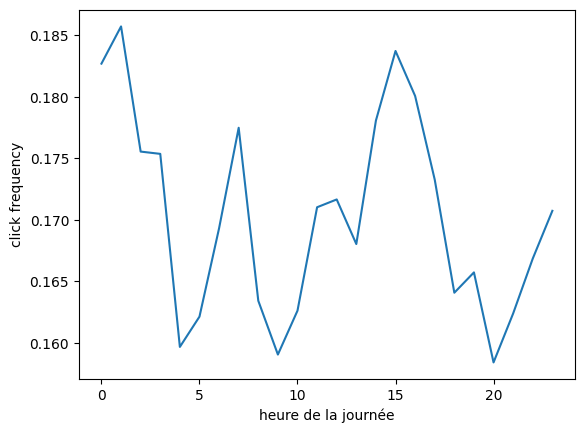

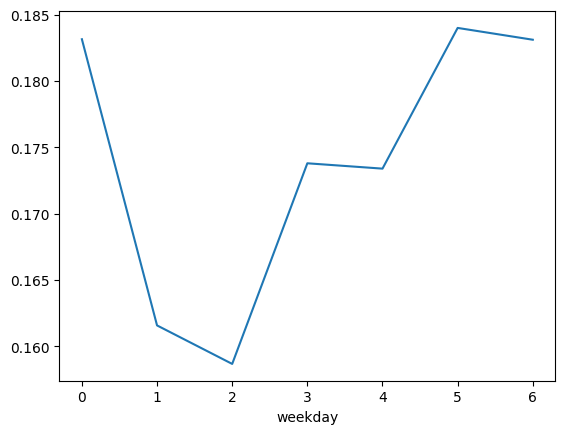

In [14]:
df.groupby('hour')['click'].mean().plot()
plt.xlabel('heure de la journée')
plt.ylabel('click frequency')
plt.show() # Fill here for the influence of the hour

df.groupby('weekday')['click'].mean().plot()
plt.show() # Fill here for the influence of the day

# Preliminary work and first model

Start by understanding the features with few modalities:
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

<font color="red">**Question:**
    For instance, inspect the columns 'C15' (dimension of the advert) and 'site_category': visualize the clicks mean.
</font>

In [15]:
print(df.groupby('C15')['click'].mean())

C15
120     0.033708
216     0.129612
300     0.360537
320     0.158767
480     0.285714
728     0.054144
768     0.375000
1024    0.166667
Name: click, dtype: float64


In [16]:
print(df.groupby('site_category')['click'].mean())

site_category
0569f928    0.053613
28905ebd    0.208076
335d28a8    0.089824
3e814130    0.284245
42a36e14    0.225806
50e219e0    0.128597
5378d028    0.000000
70fb0e29    0.144737
72722551    0.059172
75fa27f6    0.111305
76b2941d    0.035756
8fd0aea4    0.015873
9ccfa2ea    0.000000
a818d37a    0.000000
bcf865d9    0.000000
c0dd3be3    0.128655
c706e647    0.000000
da34532e    0.000000
dedf689d    0.530449
e787de0e    0.000000
f028772b    0.179719
f66779e6    0.034564
Name: click, dtype: float64


<font color="red">**Question:**
    Some site categories have a null click rate. Why? Display the 'count()' of each modality.
    <br><br>
    Hint: you can use the method ".value_counts()"
</font>

In [17]:
df['site_category'].value_counts() # Fill here

site_category
50e219e0    408921
f028772b    313339
28905ebd    182020
3e814130     75667
f66779e6      6365
75fa27f6      4007
335d28a8      3351
76b2941d      2573
c0dd3be3      1026
72722551       676
dedf689d       624
70fb0e29       608
0569f928       429
8fd0aea4       189
a818d37a        81
42a36e14        62
e787de0e        28
bcf865d9        16
5378d028        11
9ccfa2ea         5
da34532e         1
c706e647         1
Name: count, dtype: int64

It is practical to visualize both columns in parallel:

In [18]:
col = 'site_category'
a = pd.DataFrame([df.groupby(col)['click'].mean(), df.groupby(col)['click'].count()]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count', ascending=False)

,mean,count
site_category,,
50e219e0,0.128597,408921.0
f028772b,0.179719,313339.0
28905ebd,0.208076,182020.0
3e814130,0.284245,75667.0
f66779e6,0.034564,6365.0
75fa27f6,0.111305,4007.0
335d28a8,0.089824,3351.0
76b2941d,0.035756,2573.0
c0dd3be3,0.128655,1026.0


Your answer here

...

<font color="red">**Question:**
    Divide the dataset into a training and test set with sklearn (use the following options: test_size=0.1, random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [19]:
from sklearn.model_selection import train_test_split

X = df.drop(['id','click'], axis=1)
y = df['click']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.1,random_state=100)

AttributeError: module 'scipy.sparse' has no attribute 'linalg'

# First work on a reduced number of features

<font color="red">**Question:**
    Put in a list the selected columns: 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.
</font>

In [ ]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category',
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

<font color="red">**Question:**
    <br>
    - Import OneHotEncoder from sklearn.preprocessing
    <br>
    - Transform the training and the test data restricted to the selected columns
</font>

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(Xtrain[some_columns])

Xtrain_oh = ohe.transform(Xtrain[some_columns]) # fit the transformation of Xtrain restricted to selected columns
Xtest_oh = ohe.transform(Xtest[some_columns]) #and transform Xtest restricted to selected columns


<font color="red">**Question:**
    What is the new number of features?
</font>

In [ ]:
print(Xtest_oh.shape[1])

183


Your answer here

...

<font color="red">**Question:**
    Visualize the first row of the design matrix you have got. Do not forget to convert it into a "numpy.array" using the method ".toarray()".
</font>

In [ ]:
Xtrain_oh[0].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

<font color="red">**Question:**
    Import and fit a logistic regression model on your the encoded data.
</font>

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(Xtrain_oh, ytrain)


LogisticRegression(max_iter=1000)

<font color="red">**Question:**
    With '.predict' and 'predict_proba', display the hard and soft decision you get on test data.
</font>

In [ ]:
hard=lr.predict(Xtest_oh)
soft=lr.predict_proba(Xtest_oh)[:,1]

<font color="red">**Question:**
    Compute the probability of error using sklearn.metrics 'accuracy_score' function. Comment.
</font>

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, hard) # Fill here

0.83045

Your answer here

...

<font color="red">**Question:**
    Plot the ROC curve. Then compute the log loss and the Area Under the Curve ROC.
</font>

Text(0.5, 1.0, 'ROC curve')

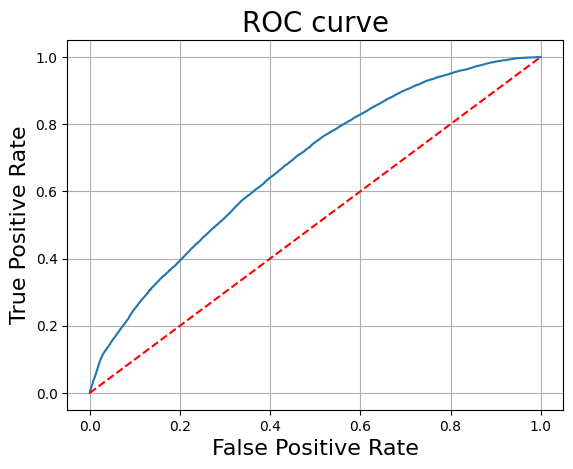

In [ ]:
from sklearn.metrics import roc_curve

false_pos_rate, true_pos_rate, _ = roc_curve(ytest, soft)
plt.plot(false_pos_rate, true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)

In [ ]:
from sklearn.metrics import log_loss , roc_auc_score

log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.4251789966298221, np.float64(0.676061763713435))

# Complete model

As an example, we now focus on the 'site_id' column.

<font color="red">**Question:**
    <br>
    - For each modality, compute the number of occurrences in the dataset and the average of clicks for this modality
    <br>
    - With 'sns.joiplot', represent the set of points (count, mean) for each modality
</font>

In [ ]:
import seaborn as sns

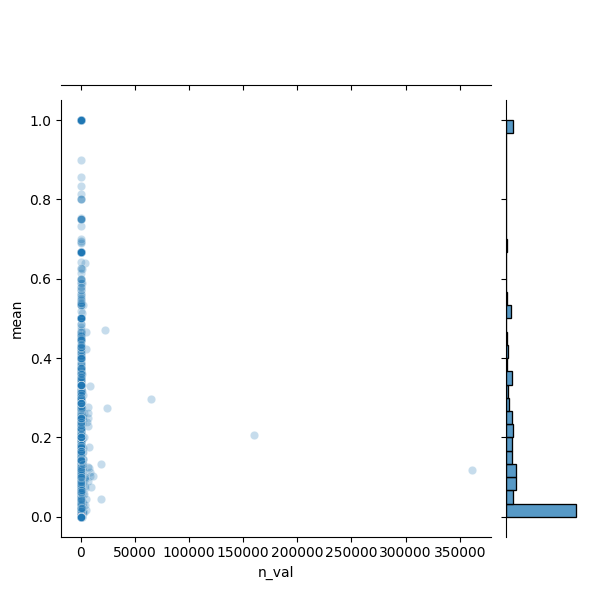

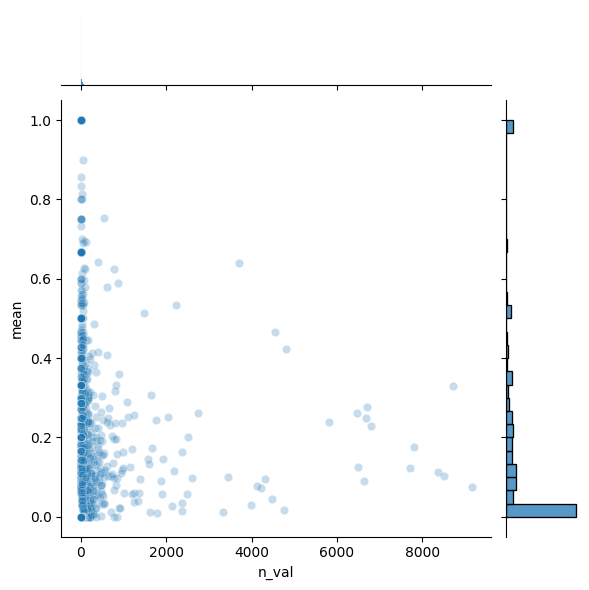

In [ ]:
col = 'site_id'
a = pd.DataFrame([df.groupby(col)['click'].mean(), df.groupby(col)['click'].count()]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(x=a['n_val'], y=a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(x=a[a['n_val']<thres]['n_val'], y=a[a['n_val']<thres]['mean'], alpha=0.25);

<font color="red">**Question:**
    In the above commands, what does the alpha parameter stand for?
</font>

Your answer here

...

Several sites with a lot of occurrences in the dataset have a click frequency very different from the mean. It is relevant to keep the column 'site_id' at least for the modalities for which 'count' is very high.

<font color="red">**Question:**
    Do the same work on the 'device_id' column. What do you notice? What could be the isolated point?
</font>

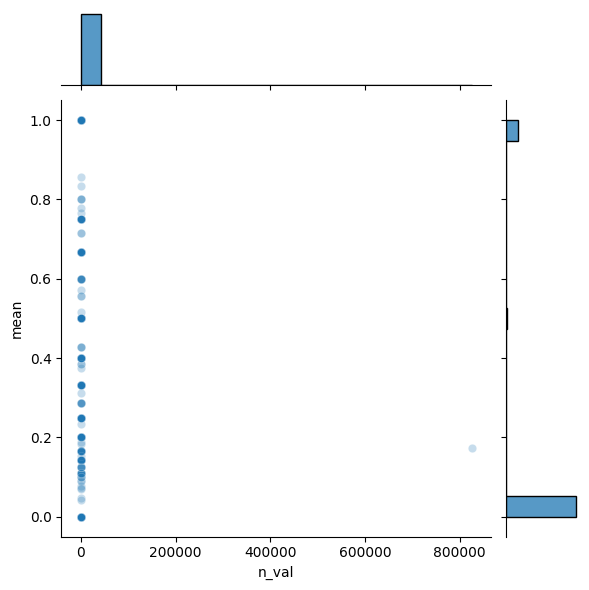

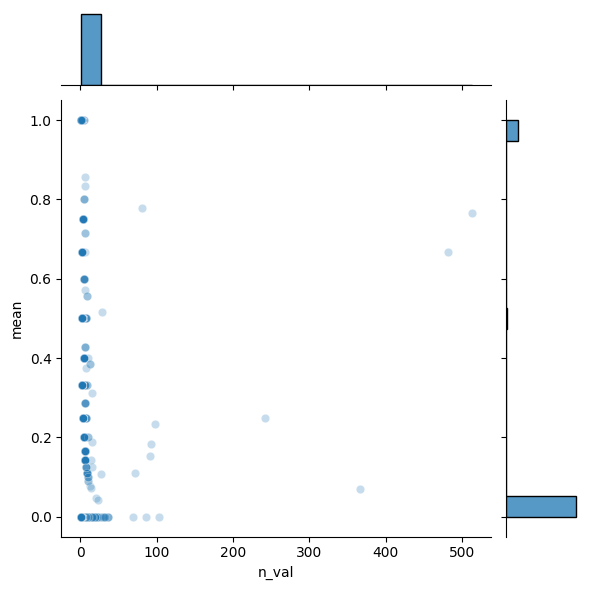

In [ ]:
col = 'device_id' # Fill here
a = pd.DataFrame([df.groupby(col)['click'].mean(), df.groupby(col)['click'].count()]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(x=a['n_val'], y=a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(x=a[a['n_val']<thres]['n_val'], y=a[a['n_val']<thres]['mean'], alpha=0.25);

Your answer here

...

<font color="red">**Question**:   
    In the column df['device_id'], spot the value V corresponding to the largest number of 'count' (using '.value_counts' method). Create a new column df['user'] defined as follows:
</font>
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{if device_id = V}\\ \text{device_id} & \text{else.}\end{array}\right.
$$

In [ ]:
V = df['device_id'].value_counts().index[0]
df['user'] = (df['device_ip'] + df['device_model']) * (df['device_id']==V) + df['device_id'] * (df['device_id']!=V)

In [ ]:
print(df['user'])

0         fb6566d3be87996b
1                 9b7af851
2         748e298a3c55fad5
3         a50da3d4c5cc73c1
4         d5f88679a5bce124
                ...       
999995    9a8dbe7f68dabce1
999996    3b6f9f67c6263d8a
999997    2348915f744ae245
999998    3ca7f7193e7932d7
999999            572e7feb
Name: user, Length: 1000000, dtype: object


<font color="red">**Question**:
    Drop in place the following columns: 'device_id', 'device_model' and 'device_ip'
</font>

In [ ]:
df.drop(columns=['device_id','device_model','device_ip'], inplace=True) #Fill here

<font color="red">**Question**:
    One could look at the similarity between 'site_id' and 'site_domain'. Merge those columns into a new 'site' column (using the '+' operator)  and delete the old 'site_id' and 'site_domain' columns.
</font>

In [ ]:
df['site'] = df['site_id'] + df['site_domain']
df.drop(columns=['site_id','site_domain'], inplace=True) #Fill here

<font color="red">**Question**:
    Once again, split the modified DataFrame 'df' into a train and a test set (with options: test_size=0.1 and random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X = df.drop(columns=['id','click'], axis='1')
y = df['click']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=100)


<font color="red">**Question**:
    Define a OneHotEncoder and then, 'fit_transform' the train set.
</font>

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore')
Xtrain_oh = ohe.fit_transform(Xtrain)

<font color="red">**Question**:
    Transform the test set. If an error occurs, analyze it and try to solve it by modifying the parameter "handle_unkown" of the OneHotEncoder.
    <br>
    Explain your the problem you encouter and how you solved it.
</font>

In [ ]:

Xtest_oh = ohe.transform(Xtest)

Your answer here

...

<font color="red">**Question**:
    What is the new number of features?
</font>

In [ ]:
print(Xtest_oh.shape[1])

713334


Your answer here

...

<font color="red">**Question**:
    How many modalities have been seen more than a 100 times?
</font>

In [ ]:
n_ones = np.array(Xtrain_oh.sum(axis=0))

[[1.8913e+04 2.2163e+04 2.7384e+04 ... 2.0000e+01 2.0000e+00 3.0000e+00]]


Your answer here

...

The list 'cols_to_keep' below is used to store the indices of the modalities seen more than a 100 times.

<font color="red">**Remark**:
    Note how the `enumerate` function works
</font>

In [ ]:
useful = np.array(n_ones>100)[0]
cols_to_keep = [i for i,b in enumerate(useful) if b]

Your answer here

...

<font color="red">**Question**:
    Using only our restriction on the 'cols_to_keep' columns, retrain a logistic regression model and compare its performance in terms of 'log_loss' and 'roc_auc_curve'.
</font>

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
Xtrain_oh_ck=Xtrain_oh[cols_to_keep]
lr.fit(Xtrain_oh_ck, ytrain[cols_to_keep])
print(soft)

KeyError: '[20, 24, 31, 35, 46, 56, 59, 176, 544, 846, 968, 1042, 1545, 1579, 1679, 1830, 1931, 2206, 2225, 2408, 2425, 2609, 2867, 2875, 3218, 3236, 3335, 3344, 3357, 3389, 3391, 3392, 3426, 3442, 3590, 3591, 3594, 3595, 3607, 3626, 3633, 3637, 3667, 3678, 3685, 3687, 3688, 3689, 3829, 3858, 3879, 3880, 3903, 3965, 3984, 4013, 4040, 4065, 4139, 4149, 4173, 4183, 4203, 4208, 4210, 4251, 4255, 4259, 4263, 4274, 4302, 4310, 4312, 4352, 4370, 4463, 4489, 4503, 4504, 4554, 4566, 4587, 4644, 4652, 4726, 4730, 4754, 4757, 4772, 4814, 4817, 4899, 4910, 4912, 5069, 5074, 5150, 5167, 5305, 5311, 5333, 5407, 5408, 5414, 5423, 5567, 5571, 5592, 5593, 5596, 5614, 5618, 5619, 5648, 5687, 5703, 5704, 5707, 5715, 5717, 5739, 5764, 5784, 5792, 5834, 5841, 5878, 5884, 5897, 5922, 5924, 5930, 5943, 5950, 5953, 5962, 5969, 6009, 6019, 6102, 6119, 6122, 6132, 6135, 6140, 6146, 6161, 6183, 6205, 6207, 6208, 6218, 6239, 6244, 6260, 6263, 6270, 6275, 6278, 6282, 6287, 6300, 6303, 135578, 205266, 487748, 707926, 708324, 708511, 708525, 708736, 709096, 709314, 709398, 709838, 709985, 710233, 710315, 710485, 710903, 710987, 711239, 711241, 711253, 711412, 711547, 711593, 711825, 711888, 712068, 712096, 712296, 712395, 712647, 712708, 713112, 713130] not in index'

In [ ]:
from sklearn.metrics import accuracy_score

soft = lr.predict_proba(Xtest_oh)[:,1]
hard = lr.predict(Xtest_oh)

print(accuracy_score(ytest,hard))

0.83416


# Gradient Boosting Decision Trees

<font color="red">**Question**:
    <br>
    - Import GradientBoostingClassifier from scikit learn.
    <br>
    - Initialize it using 50 estimators and a learning rate of 0.8. Set 'verbose=True' to monitor the progress of the training step.
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance as in the previous step.
</font>

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.8,
    verbose=True
)

KeyboardInterrupt: 

In [ ]:
gb.fit(Xtrain_oh, ytest)

NameError: name 'gb' is not defined

In [ ]:
soft = ...
log_loss(ytest, soft), roc_auc_score(ytest, soft)

<font color="red">**Question**:
    What does the 'gb.estimators_' output?
</font>

Your answer here

...

We now try to use the 'gb' classifier to generate features that will be relevant inputs for the logistic regression.

<font color="red">**Question**:
    With the 'gb.apply()' method, generate a transformation 'leafs_train' of the training set 'Xtrain_oh[:, cols_to_keep]' for which the n-th column corresponds to the number of the leaf returned by the estimator n.
</font>

In [ ]:
# Test here the gb.apply method on Xtrain[:, cols_to_keep]


After your applied gb.apply on Xtrain_oh[:, cols_to_keep], remember that we have only one class to predict (click = 0 or 1). So, do not forget to slice your output with [:, :, 0] in order to keep, firstly, all the samples, and secondly all your 50 estimators.

Hint: you can have a look at the dimensions of your output with .shape !

In [ ]:
leafs_train = pd.DataFrame( ... ) # Fill here
leafs_test = pd.DataFrame( ... )

<font color="red">**Question**:
    Encode these new features into dummies.
</font>

In [ ]:
ohe = OneHotEncoder( ... ) # Fill here an argument if needed
leafs_train_oh = ...
leafs_test_oh = ...

<font color="red">**Question**:
    With the "hstack" function, create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]").
</font>
<br><br>
**Remark**: we use "hstack" from scipy.sparse (and not from numpy) because the output of our OneHotEncoder is a sparse array. You can verify it with the command "type(Xtrain_oh)".

In [ ]:
from scipy.sparse import csr_matrix, hstack

Xtrain_concat = hstack([ ... , ... ]) # Fill here
Xtest_concat = ...

<font color="red">**Question**:
    Run a logistic regression on the new features and evaluate its performance as before.
    <br>
    Warning: be patient, fitting should take about 5 minutes on Google Colab.
</font>

# XGBoost

<font color="red">**Question**:
    <br>
    - Import XGBClassifier from xgboost package.
    <br>
    - Initialize it using the same number of estimators and learning rate as before. Set the 'n_jobs' to -1.
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance and compare it to the GradientBoosting classifier of scikit learn. How is the error? Does it take more time to run?
</font>

In [ ]:
from xgboost import ...

xgb = XGBClassifier( ... , ... , ... , verbosity=2)
%time xgb.fit( ... )
...

<font color="red">**Question**:
    Increase the number of estimators and visualize the impact on performance. You might have to adapt the learning rate. On Google Colab, here are the approximate training times<br>
    - nb_estimators=256  and lr=0.8 ~  4 min<br>
    - nb_estimators=512  and lr=0.6 ~  8 min<br>
    - nb_estimators=1024 and lr=0.5 ~ 16 min
</font>

In [ ]:
xgb = XGBClassifier( ... , ... , ... )


# Features hashing and random forest

We restart with raw features before dummy encoding: Xtrain, Xtest.

<font color="red">**Question**:
    Display again the number of modalities per feature in Xtrain. Use '.nunique()'
</font>

In [ ]:
# Fill here

We want to define a transformation which regroups the least frequent modalities into a label 'isRare'. In order to do so, we decide to define our own Transformer.

<font color="red">**Question**:
    Understand the different steps of 'fit' and 'transform'.
</font>

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):

            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ?
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ?
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ?

        ######################################################

        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


<font color="red">**Question:**
    <br>
    - Fit and transform the training set. To do so, merge all mmodalities occuring at least 20 times in each column.
    <br>
    - Transform the test set.
</font>

In [ ]:
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_mg = ... # Fill here with fit_transform
Xtest_mg =

<font color="red">**Question:**
   How many elements of the column Xtrain_mg['app_domain'] are now labeled as 'rare'? Use the '.value_counts()' method.
</font>

In [ ]:
# Fill here

<font color="red">**Question:**
   In the new train set, display the number of modalities for each feature.
</font>

In [ ]:
# Fill here

Modalities are arbitrary object, such as '234', 'isRare', etc. We will now transorm them into integers with the hashing trick.

<font color="red">**Question:**
   To better understand how the 'hash' function is working, apply it to a string of your choice.
</font>

In [ ]:
import hashlib
hash( ... ) # Fill here

<font color="red">**Question:**
   Create two new datasets 'Xtrain_ha' and 'Xtest_ha' containing the output of the hashing process. Use the '.apply' method to transform iteratively the columns by mapping to each value its remainder in the euclidean division of the hash by 1000000.
   Example:
</font>
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>
Remark: do not forget that the function 'hash' has to take a string as input.

In [ ]:
Xtrain_ha = pd.DataFrame()
Xtest_ha = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply(lambda ... ) # Fill here defining a lambda function
    Xtest_ha[col] = Xtest_mg[col].apply(lambda ... )

<font color="red">**Question:**
   Visualize the content of the DataFrames you have obtained.
</font>

In [ ]:
# Fill here

<font color="red">**Question:**
    <br>
    - Train a RandomForestClassifier on Xtrain_ha and evaluate its performance on Xtest_ha. Chose 256 estimators, min_samples_leaf=20 and verbose=1 in order to monitor the fitting step. (If you have enough time, try later with 1024 estimators and min_samples_leaf=20).
    <br>
    - How do you fix 'n_jobs'?
</font>

In [ ]:
from sklearn.ensemble import ... # Fill here
rf = RandomForestClassifier( ... )
rf.fit( ... )

In [ ]:
soft = ...
log_loss(ytest, soft), roc_auc_score(ytest, soft)

<font color="red">**Question:**
   Compare with xgboost performance on the same hashed dataset, with n_estimators=256, n_jobs=-1, learning_rate=1.0. (If you have enough time try n_estimators=1024, n_jobs=-1, learning_rate=0.5, it will perform better than a Random Forest of 1024 trees).
</font>

In [ ]:
... # Fill here
%time xgb.fit( ..., ... ) # the '%time' command will return the execution time of the fitting step
...

<font color="red">**Question:**
    Plot the ROC curve for the obtained classifier (xgboost on hashed data).
</font>

In [ ]:
# Plot the ROC curve here

Your answer here

...

Good job! :-)

<font color="red">**Bonus Question:**
    If you have enough time (about 2 hours ...), try to fit both random forest and xgboost models with more estimators (and a different learning rate of 0.5 for xgboost) on these enlarged datasets.<br>
</font>

In [ ]:
# Fill here

# BONUS : Field-aware Factorization Machines
<br>
<font color="red">
Display the names of the columns of the matrix Xtrain_ha
</font>

<font color="red">
Create a list of lists of the columns. The n-th sub-list is composed of the names of the columns of the n-th field.</font>

In [ ]:
fields = []
fields.append( liste_colonnes_du_premier_champ )
fields.append( liste_colonnes_du_deuxième_champ )
fields.append( etc. )


<font color="red">
With the enumerate function, let generate a dictionary which associates each column name with its field.


In [ ]:
dicFields = { ... : ...  for i,f in enumerate(fields) for name_col in f}

We need to make sure that two different columns have different modalities. For this, we add in front of each modality a characteristic string of the column.

<font color="red">Perform this transformation with the apply method</font>


In [ ]:
Xtrain_ffm = pd.DataFrame()
Xtest_ffm = pd.DataFrame()
for col in Xtrain_ha.columns:
    Xtrain_ffm[col] = Xtrain_ha[col].apply( ... )
    Xtest_ffm[col] = Xtest_ha[col].apply( ... )

With np.unique, we create the list of all the modalities appearing in all the columns.

In [ ]:
allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_ffm[col]))
allvals= [val for sublist in allvals for val in sublist]

<font color="red">
Using enumerate method, create a dictionary that at each value associates its rank in the allvals list.</font>

In [ ]:
dicFeat = {val:i for i,val in ... }

We build dataframe from dicFeat as follows:
in each "col" column, the value "x" is replaced by the string "f: v: 1", where f is the field associated with the column and v is the index of the modality x.
<font color="red">
Study the following code</font>

In [ ]:
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_ffm[col] = Xtrain_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col] = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

<font color="red">For the two resulting dataframes, concatenate on the left the corresponding ytrain (or ytest) click column</font>

In [ ]:
yXtrain_ffm = pd.concat( ... ,axis=1)
yXtest_ffm = pd.concat( ... ,axis=1)

<font color="red">What does the following cell produce?</font>

In [ ]:
train_w = yXtrain_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_w = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values

<font color="red">Write the above dataframe in a text file</font>

In [ ]:
thefile = open('train.txt','w')
for item in train_w:
    thefile.write("%s\n" % item)

# Faire de même pour le test set


To learn the FFM model, we use the LibFFM library https://www.csie.ntu.edu.tw/~cjlin/libffm/
In the notebooks / directory there are two executables: ffm-train and ffm-predict.
In jupyter notebook, the exclamation point! allows to launch a bash command.
The use is as follows:

-   `ffm-train'

    usage: ffm-train [options] training_set_file [model_file]

    options:  
    -l <lambda>: set regularization parameter (default 0.00002)  
    -k <factor>: set number of latent factors (default 4)  
    -t <iteration>: set number of iterations (default 15)  
    -r <eta>: set learning rate (default 0.2)  
    -s <nr_threads>: set number of threads (default 1)  
    -p <path>: set path to the validation set  
    --quiet: quiet model (no output)  
    --no-norm: disable instance-wise normalization  
    --auto-stop: stop at the iteration that achieves the best validation loss (must be used with -p)  
<br>
<font color="red">Learn the model. We can :
- use an regularizer of 0.00001
- use a learning rate of 0.05
- use of the order of 15 latent factors
- carry out the order of 30 iterations
- with the -p option, change the test file to validation parameters
- activate the --autostop mode
</font>

The use of ffm-predict is: ffm-predict filename-test file-name-model file-in-which-write-the-prediction
<font color="red">Perform the prediction</font>

<font color="red">Compute the log_loss and area under the roc curve (ROC AUC).</font>

# Bonus 2 : blending

<font color="red">
Split Xtrain in two: Xtrain_meth and Xtrain_blend.</font>

In [ ]:
Xtrain_meth, Xtrain_blend, ytrain_meth, ytrain_blend = train_test_split(Xtrain_ha,ytrain,test_size=0.2)

<font color="red">
Train a logistic regression on XTrain_meth. Then compute its score on Xtrain_blend and save the score in a vector.</font>

<font color="red">
Do the same thing with XGBoost (save the score).</font>

<font color="red">
Do the same with a RandomForest (save the score).</font>

<font color="red">
Now with an extraTrees.</font>

<font color="red">
And again with FFM.</font>

<font color="red">
Concatenate all scores on Xtrain_blend to form a Zblend design matrix.</font>

<font color="red">
Train a logistic regression on (Zblend,ytrain_blend).</font>

<font color="red">
Evaluate the performance of this model on the test dataset.</font>